(tut_eop_data)=

# Working with EOP data

```{versionadded} 7.3.0

```

heyoka.py provides the ability to access [Earth orientation parameters](https://en.wikipedia.org/wiki/Earth_orientation_parameters) (EOP) data and even use it in the [expression system](<./The expression system.ipynb>). This makes it possible to formulate ODEs accounting for precise information about the Earth's orientation.
With this capability, users can model dynamical systems with greater accuracy, incorporating real-world variations in the Earth's rotation and pole position directly into their simulations.

## Accessing the raw data

The raw EOP data is encapsulated in the {py:class}`~heyoka.eop_data` class. Let us explore it a bit.

In [1]:
# Default-construct an eop_data instance.
import heyoka as hy

data = hy.eop_data()

The raw data is available via the {py:attr}`~heyoka.eop_data.table` property, which returns a {ref}`structured NumPy array<numpy:defining-structured-types>` containing a time series of the EOP data:

In [2]:
data.table

array([(41684., 0.8075   , 0.143   , 0.137   , -1.8637e+01, -3.667),
       (41685., 0.8044   , 0.141   , 0.134   , -1.8636e+01, -3.571),
       (41686., 0.8012   , 0.139   , 0.131   , -1.8669e+01, -3.621), ...,
       (60836., 0.0394946, 0.132807, 0.430648,  0.0000e+00,  0.071),
       (60837., 0.0404892, 0.134271, 0.430747,  0.0000e+00,  0.066),
       (60838., 0.0415893, 0.135736, 0.430823, -2.0000e-03,  0.062)],
      shape=(19155,), dtype={'names': ['mjd', 'delta_ut1_utc', 'pm_x', 'pm_y', 'dX', 'dY'], 'formats': ['<f8', '<f8', '<f8', '<f8', '<f8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40], 'itemsize': 48, 'aligned': True})

The dtype of the array is {py:attr}`~heyoka.eop_data_row`, which includes:

- the UTC MJD (``mjd``),
- the UT1-UTC difference in seconds (``delta_ut1_utc``),
- the $x$ component of the [polar motion](https://en.wikipedia.org/wiki/Polar_motion) in arcsecs (``pm_x``),
- the $y$ component of the polar motion in arcsecs (``pm_y``),
- the $x$ component of the correction to the IAU 2000/2006
  precession/nutation model in milliarcsecs (``dX``),
- the $y$ component of the correction to the IAU 2000/2006
  precession/nutation model in milliarcsecs (``dY``).

## Updating the EOP data

A default-constructed {py:class}`~heyoka.eop_data` instance uses a builtin EOP dataset from the [IERS datacenter](https://datacenter.iers.org/eop.php) (``"finals2000A.all"``). This dataset is comprehensive, including both historical data dating back to the 70s and predictions for the near future.

Although the builtin dataset is updated at every new heyoka.py release, it is likely to be outdated, at least for operational uses. For this reason, the {py:class}`~heyoka.eop_data` class provides static factory methods to construct {py:class}`~heyoka.eop_data` instances from up-to-date datasets downloaded from the internet.

As an example, we can use {py:func}`~heyoka.eop_data.fetch_latest_iers_rapid()` to download the ``"finals2000A.daily"`` [dataset](https://datacenter.iers.org/versionMetadata.php?filename=latestVersionMeta/12_FINALS.DAILY_IAU1980_V2013_0112.txt), which contains EOP data and predictions for an interval of 180 days around the present time:

In [ ]:
updated_data = hy.eop_data.fetch_latest_iers_rapid(filename = "finals2000A.daily")

Please see the documentation of {py:class}`~heyoka.eop_data` for more detailed information.

## Using the EOP data in the expression system

The EOP data can also be used in the expression system via several functions available in the {ref}`model<api_model>` submodule. These currently include:

- the [Earth rotational angle](https://en.wikipedia.org/wiki/Sidereal_time#ERA) {py:func}`~heyoka.model.era()` and its derivative,
- the [Greenwich mean sidereal time](https://en.wikipedia.org/wiki/Sidereal_time#Mean_and_apparent_varieties) {py:func}`~heyoka.model.gmst82()` and its derivative,
- the polar motion angles {py:func}`~heyoka.model.pm_x()` and {py:func}`~heyoka.model.pm_y()` and their derivatives,
- the corrections to the IAU 2000/2006 precession/nutation model {py:func}`~heyoka.model.dX()` and {py:func}`~heyoka.model.dY()` and their derivatives.

The functions are all implemented as [piecewise linear functions](https://en.wikipedia.org/wiki/Piecewise_linear_function) of the input time. That is, the EOP quantities are approximated via linear interpolation between the dates in the EOP dataset.

All these functions take in input a time expression meant to represent the number of Julian centuries elapsed since the epoch of J2000 in the [terrestrial time (TT) timescale](https://en.wikipedia.org/wiki/Terrestrial_Time). They also accept as a second argument the {py:class}`~heyoka.eop_data` dataset to be used in the computation. The return values are angles expressed in radians.

Here is an example of computation and visualisation of the time evolution of the [polar motion](https://en.wikipedia.org/wiki/Polar_motion) angles using heyoka.py's [compiled functions](<./compiled_functions.ipynb>):

In [4]:
import numpy as np

# Define the computation timespan: 10 years following J2000.
tspan = np.linspace(0, 0.1, 1000)

# Introduce a symbolic variable for the representation of time.
tm = hy.make_vars("tm")

# Construct a compiled function for the computation of the polar motion angles.
cf = hy.cfunc([hy.model.pm_x(time_expr=tm), hy.model.pm_y(time_expr=tm)], [tm])

# Compute the values of the polar motion angles over tspan.
pm_x, pm_y = cf(inputs=[tspan])

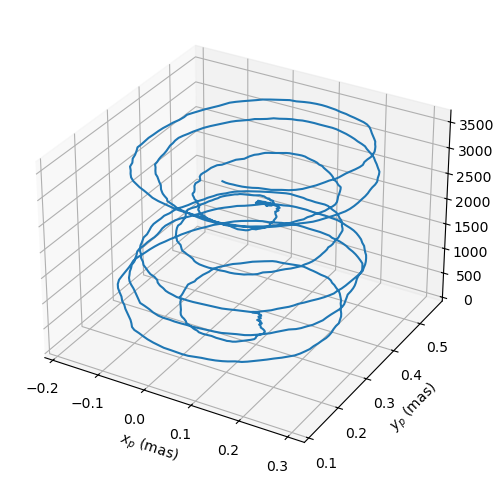

In [7]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")

# Convert the angles to arcsec and the timespan
# to days for visualisation.
rad_to_arcsec = 180 * 3600 / np.pi
cy_to_days = 36525

ax.plot(pm_x * rad_to_arcsec, pm_y * rad_to_arcsec, tspan * cy_to_days)
ax.set_xlabel("$x_p$ (arcsec)")
ax.set_ylabel("$y_p$ (arcsec)");